# Spline Flow: Three Concentric Rings

**Goal**: Test that a spline-based normalizing flow can learn a multi-modal 2D distribution.

## Problem Setup

The target distribution is a mixture of three concentric rings centered at the origin:

```
x = (r_i · cos(θ), r_i · sin(θ)) + ε,    θ ~ Uniform(0, 2π),    ε ~ N(0, σ²)
```

where:
- `x ∈ R²` is the 2D position
- `r_i ∈ {1, 2, 3}` is the radius of ring `i` (chosen uniformly)
- `θ` is a random angle (uniform around the circle)
- `ε` is small Gaussian noise

## What This Tests

1. **Multi-modality**: The flow must capture three distinct modes (rings)
2. **Spline expressivity**: Rational-quadratic splines should handle the non-Gaussian structure
3. **Topology**: The target has disconnected support — a challenge for flows

## Evaluation

- **Visual**: Samples should form three distinct concentric rings
- **Quantitative**: Histogram of sample radii should show three peaks at r=1, 2, 3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [3]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from nflows.builders import build_spline_realnvp, build_realnvp

## Data Generation

In [28]:
RADIUS_1 = 1.0
RADIUS_2 = 2.0
RADIUS_3 = 3.0

def sample_three_rings(key, n_samples, radii=(RADIUS_1, RADIUS_2, RADIUS_3), noise_std=0.05):
    """Sample from mixture of three concentric rings.
    
    Args:
        key: JAX random key
        n_samples: Number of samples
        radii: Tuple of ring radii
        noise_std: Gaussian noise standard deviation
    
    Returns:
        Array of shape (n_samples, 2)
    """
    k1, k2, k3 = jax.random.split(key, 3)
    
    # Choose ring uniformly
    ring_idx = jax.random.randint(k1, (n_samples,), 0, len(radii))
    r = jnp.array(radii)[ring_idx]
    
    # Sample angle
    theta = jax.random.uniform(k2, (n_samples,), minval=0, maxval=2*jnp.pi)
    
    # Generate points
    x = jnp.stack([r * jnp.cos(theta), r * jnp.sin(theta)], axis=-1)
    
    # Add noise
    x = x + noise_std * jax.random.normal(k3, x.shape)
    return x

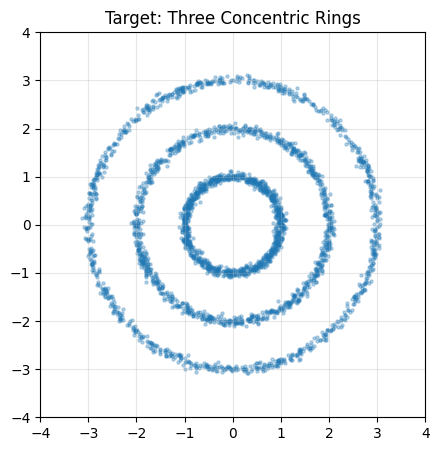

In [29]:
# Visualize target distribution
key = jax.random.PRNGKey(0)
data = sample_three_rings(key, n_samples=3000)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3, s=5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal')
plt.title('Target: Three Concentric Rings')
plt.grid(True, alpha=0.3)
plt.show()

## Build Flow

In [ ]:
key = jax.random.PRNGKey(42)

flow, params = build_spline_realnvp(
    key,
    dim=2,
    num_layers=10,
    hidden_sizes=[128, 128],
    num_bins=8,
    use_linear = True,          # add linear layers between coupling layers
    trainable_base= True,        # let the base adapt a bit
    loft_tau=20.0,
)

n_params = sum(p.size for p in jax.tree.leaves(params))
print(f"Flow built: dim=2, num_layers=8, {n_params:,} parameters")

Flow built: dim=2, num_layers=8, 228,314 parameters


## Training

In [48]:
@jax.jit
def loss_fn(params, x):
    return -flow.log_prob(params, x).mean()

@jax.jit
def train_step(params, opt_state, x):
    loss, grads = jax.value_and_grad(loss_fn)(params, x)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

lr = 1e-4
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [51]:
key = jax.random.PRNGKey(0)
losses = []
n_iter = 5000
batch_size = 256

for step in range(n_iter):
    key, subkey = jax.random.split(key)
    x = sample_three_rings(subkey, n_samples=batch_size)
    params, opt_state, loss = train_step(params, opt_state, x)
    losses.append(float(loss))
    
    if step % 500 == 0:
        print(f"Step {step}: loss = {loss:.4f}")

print(f"Final loss: {losses[-1]:.4f}")

Step 0: loss = 2.2463
Step 500: loss = 2.2119
Step 1000: loss = 2.2269
Step 1500: loss = 2.1445
Step 2000: loss = 2.1271
Step 2500: loss = 2.1924
Step 3000: loss = 2.2193
Step 3500: loss = 2.0946
Step 4000: loss = 2.3039
Step 4500: loss = 2.1915
Final loss: 2.1599


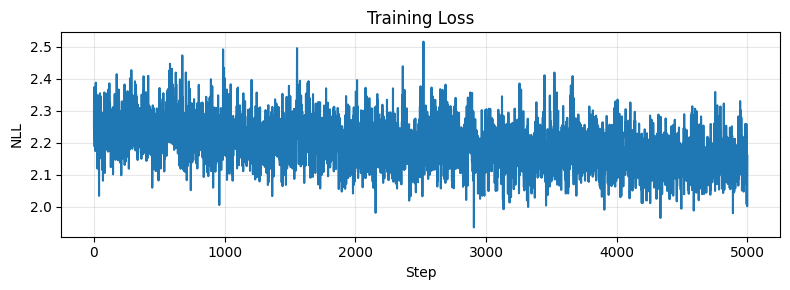

In [52]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('NLL')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluation

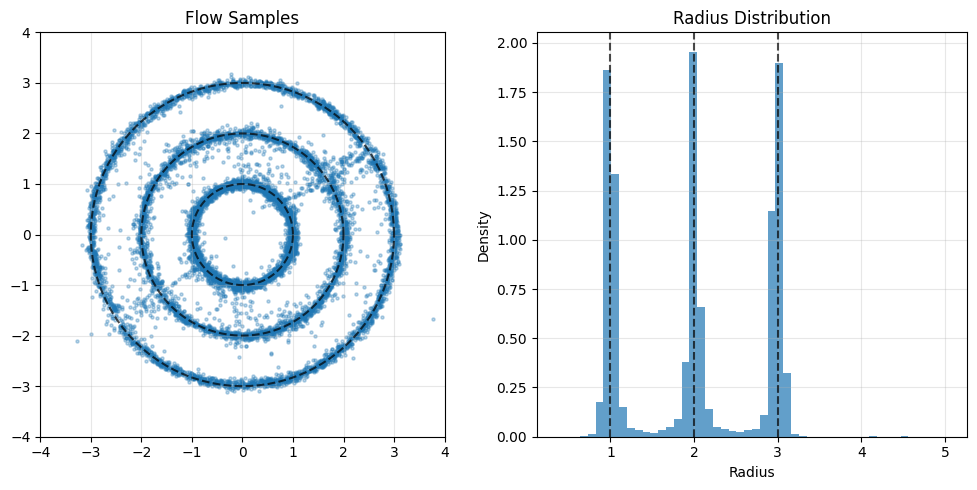

In [53]:
# Generate samples from trained flow
key = jax.random.PRNGKey(123)
n_samples = 10_000
samples = flow.sample(params, key, (n_samples,))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: scatter plot
ax = axes[0]
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=5, c='tab:blue')
# Draw target circles
theta = jnp.linspace(0, 2*jnp.pi, 100)
for r in [1.0, 2.0, 3.0]:
    ax.plot(r * jnp.cos(theta), r * jnp.sin(theta), 'k--', lw=1.5, alpha=0.7)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
ax.set_title('Flow Samples')
ax.grid(True, alpha=0.3)

# Right: radius histogram
ax = axes[1]
sample_radii = jnp.sqrt((samples**2).sum(axis=-1))
ax.hist(sample_radii, bins=50, density=True, alpha=0.7, color='tab:blue')
for r in [1.0, 2.0, 3.0]:
    ax.axvline(r, color='k', linestyle='--', lw=1.5, alpha=0.7)
ax.set_xlabel('Radius')
ax.set_ylabel('Density')
ax.set_title('Radius Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

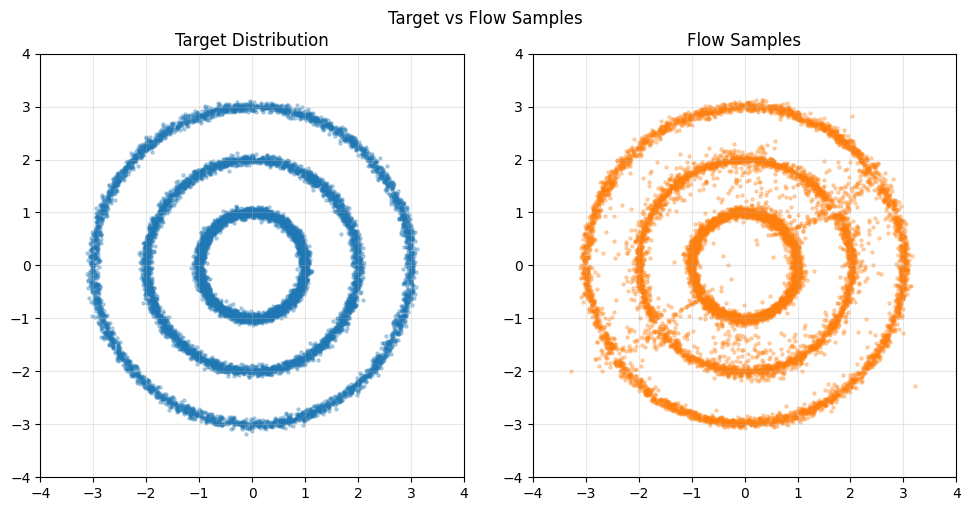

In [54]:
# Compare samples vs target side by side
key = jax.random.PRNGKey(999)
k1, k2 = jax.random.split(key)

n_samples = 10_000
target_samples = sample_three_rings(k1, n_samples=n_samples)
flow_samples = flow.sample(params, k2, (n_samples,))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.3, s=5)
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')
axes[0].set_title('Target Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(flow_samples[:, 0], flow_samples[:, 1], alpha=0.3, s=5, c='tab:orange')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
axes[1].set_title('Flow Samples')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Target vs Flow Samples')
plt.tight_layout()
plt.show()